### Covid-19 Prediction Using Chest X-ray Image

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import os
from glob import glob
import json
import os.path as osp
import sys
import math
from PIL import Image
import PIL.ImageDraw
import io
import shutil
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip

Using TensorFlow backend.


Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 117MB/s] 
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
print(os.listdir("/content/"))

#Print and remove zips once done

!rm Covid_Data_GradientCrescent.zip

['.config', 'all', 'Covid_Data_GradientCrescent.zip', 'two', 'drive', 'sample_data']


In [ ]:
from os import listdir
data_list = listdir('/content/all/train')

#Delete some classes that may interfere


data_list

['covid', 'pneumonia_bac', 'pneumonia_vir', 'normal']

In [ ]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k

In [ ]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc,roc_curve,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/COVID-19_Prediction/"

/content/drive/My Drive/COVID-19_Prediction


In [ ]:
#Define hyperparameter variable which will be used later
img_size=150
nb_classes = 4  # number of classes
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

#1. Data Collection

Both COVID-19 and NORMAL patients X-ray image data has been collected from below given open source repository.

COVID-19 Dataset :  https://github.com/ieee8023/covid-chestxray-dataset <br>

  This dataset has chest X-ray & CT scan image of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias (MERS, SARS, and ARDS.). This Data will be collected from public sources as well as through indirect collection from hospitals and physicians.

  From this dataset we have collected only COVID-19 positive patients chest X-ray image files. It has around 235 COVID-19 positive images and same downloaded into local folder.

NORMAL Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

  For NORMAL patient’s chest X-rays dataset has been collected from Kaggle. It has Normal and Pneumonia patient chest X-rays data. 
  From this dataset we have  collected 231 Normal patients X-ray images to make sure dataset are balanced with COVID-19 data.


This image files are collected into local folder as per below format,

        Dataset (Root Folder)
          -- COVID-19 (Sub-Folder)
          -- NORMAL  (Sub-Folder)

In [ ]:
train_path = '/content/all/train'
test_path = '/content/all/test'
val_path = '/content/all/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
 validation_split = 0,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (320, 320),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
val_generator = test_datagen.flow_from_directory(val_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 270 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [ ]:
train_data_dist=np.unique(train_generator.classes, return_counts=True)[1]
class_mapping_train = train_generator.class_indices
for key, val in class_mapping_train.items():
    print(f'The number of {key} images are {train_data_dist[val]} in training-set')
print('_____________________________________________________________________')
test_data_dist=np.unique(test_generator.classes, return_counts=True)[1]
class_mapping_test = test_generator.class_indices
for key, val in class_mapping_test.items():
    print(f'The number of {key} images are {test_data_dist[val]} in test-set')
print('_____________________________________________________________________')
val_data_dist=np.unique(val_generator.classes, return_counts=True)[1]
class_mapping_val = val_generator.class_indices
for key, val in class_mapping_val.items():
    print(f'The number of {key} images are {val_data_dist[val]} in validation-set')

The number of covid images are 60 in training-set
The number of normal images are 70 in training-set
The number of pneumonia_bac images are 70 in training-set
The number of pneumonia_vir images are 70 in training-set
_____________________________________________________________________
The number of covid images are 9 in test-set
The number of normal images are 9 in test-set
The number of pneumonia_bac images are 9 in test-set
The number of pneumonia_vir images are 9 in test-set
_____________________________________________________________________
The number of covid images are 9 in validation-set
The number of normal images are 9 in validation-set
The number of pneumonia_bac images are 9 in validation-set
The number of pneumonia_vir images are 9 in validation-set


In the dataframe we have 466 files are there

#2. Exploratory  Data Analysis

Sample picture from NORMAL patient X-ray Images

#3. Data Pre-Processing


In the data pre-processing stage we are do below given step to split, resize and normalize the data for modelling.


1.   Randomly Split image file dataset to Train (90%) and Test (10%).
2.   In the image pre-processing method, its get image bytes from file and resize to 150x150.
3. And then it will Normalize the image to 0-1 from 0-255.
4. Finally this method return numpy array object as X and corresponding label value as Y.
5. Invoke imagePreProcess method with train_df and get the X & Y values.
6. Randomly split X&Y value as Actual Train and Validation dataset.



# Deep Learning Image Binary Classification Model:

Here we will be using Xception model base architecture with transfer learning technique to predict COVID-19.

### Xception Model :

In [ ]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_xception_model = Xception(input_shape=(320, 320, 3), weights='imagenet', include_top=False)

In [ ]:
# Top Model Block
x = base_xception_model.output
x=Dropout(0.4)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# add your top layer block to your base model
xception_model = Model(base_xception_model.input, predictions)


In [ ]:
epochs= 100
lr = 1e-4
BS = 16

xception_model.compile(optimizer=Adam(lr=1e-4,decay=lr/epochs),
              loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [ ]:
xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 159, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 159, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 159, 159, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
# save weights of best training epoch: monitor either val_loss or val_acc
filepath= './xception_CovidVsNormal_Final_Best_model_weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [ ]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
xception_history=xception_model.fit(train_generator, 
                                    validation_data = val_generator,
                    validation_steps = 10,
                                    epochs=100,
                                    
                                    callbacks=callbacks_list)

Epoch 1/100
17/17 [==============================] - 51s 3s/step - loss: 0.9818 - accuracy: 0.5815 - val_loss: 2.2384 - val_accuracy: 0.2000

Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to ./xception_CovidVsNormal_Final_Best_model_weights.h5
Epoch 2/100
17/17 [==============================] - 31s 2s/step - loss: 0.2791 - accuracy: 0.9148 - val_loss: 0.7163 - val_accuracy: 0.2000

Epoch 00002: val_accuracy did not improve from 0.20000
Epoch 3/100
17/17 [==============================] - 31s 2s/step - loss: 0.1274 - accuracy: 0.9667 - val_loss: 1.1470 - val_accuracy: 0.7000

Epoch 00003: val_accuracy improved from 0.20000 to 0.70000, saving model to ./xception_CovidVsNormal_Final_Best_model_weights.h5
Epoch 4/100
17/17 [==============================] - 31s 2s/step - loss: 0.0700 - accuracy: 0.9889 - val_loss: 0.8735 - val_accuracy: 0.4000

Epoch 00004: val_accuracy did not improve from 0.70000
Epoch 5/100
17/17 [==============================] - 31s 2s/step - 

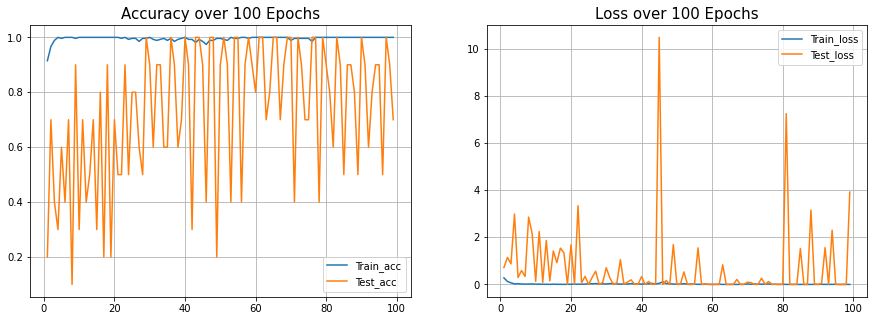

In [ ]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(xception_history, 100)

# Validation Data Prediction

In [ ]:
from tensorflow.keras.models import load_model
filepath= './xception_CovidVsNormal_Final_Best_model_weights.h5'
new_model = load_model(filepath)
prediction=new_model.predict(test_generator, use_multiprocessing=True)
print(prediction)

[[9.99994636e-01 1.25560484e-06 1.00535124e-06 3.03459501e-06]
 [9.99994755e-01 2.57521924e-06 1.47648325e-06 1.09397342e-06]
 [9.99974370e-01 7.05804587e-06 7.21963670e-06 1.14198938e-05]
 [9.97297823e-01 1.04521634e-03 2.93754401e-05 1.62760599e-03]
 [9.99848843e-01 9.72112466e-05 4.48917417e-05 9.01789826e-06]
 [9.99426961e-01 3.98410957e-05 4.60305775e-04 7.29503081e-05]
 [9.99920607e-01 1.67790149e-05 1.67537110e-06 6.08900846e-05]
 [9.99789178e-01 5.74058249e-05 7.04352715e-06 1.46314240e-04]
 [9.99280274e-01 2.06286189e-04 3.07588525e-05 4.82652191e-04]
 [1.12296706e-02 9.76354897e-01 1.15247462e-02 8.90654628e-04]
 [7.84040149e-03 7.46044159e-01 2.45330602e-01 7.84830132e-04]
 [5.86551204e-02 9.15173650e-01 2.06247047e-02 5.54651953e-03]
 [4.55506109e-02 9.39114869e-01 4.57028067e-03 1.07642533e-02]
 [6.96441531e-02 3.55786532e-01 2.90808558e-01 2.83760816e-01]
 [7.69595355e-02 8.09948504e-01 9.88150537e-02 1.42769488e-02]
 [6.83639618e-03 9.79488075e-01 9.93346889e-03 3.742065

Confusion matrix, without normalization


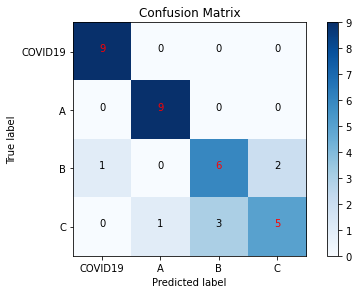

Normalized confusion matrix


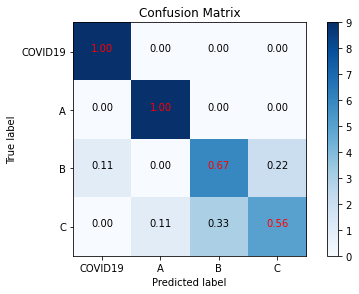

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
y_pred = np.argmax(prediction, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)

cm_labels= ['COVID19','A','B','C']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', normalize=True)

prob:[9.9999464e-01 1.2556048e-06 1.0053512e-06 3.0345950e-06]
covid/nejmoa2001191_f3-PA.jpeg


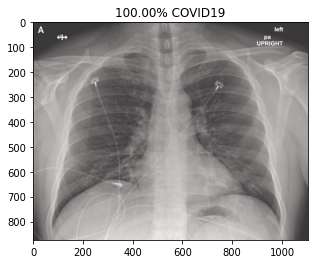

prob:[9.9999475e-01 2.5752192e-06 1.4764832e-06 1.0939734e-06]
covid/nejmoa2001191_f4.jpeg


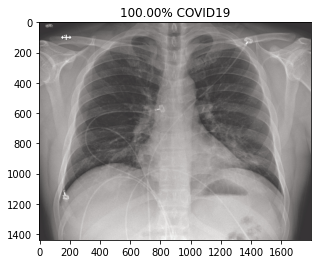

prob:[9.9997437e-01 7.0580459e-06 7.2196367e-06 1.1419894e-05]
covid/nejmoa2001191_f5-PA.jpeg


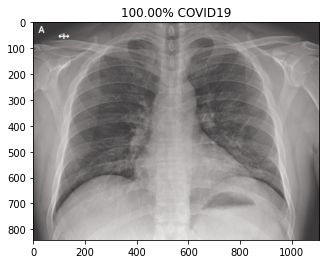

prob:[9.9729782e-01 1.0452163e-03 2.9375440e-05 1.6276060e-03]
covid/radiol.2020200490.fig3.jpeg


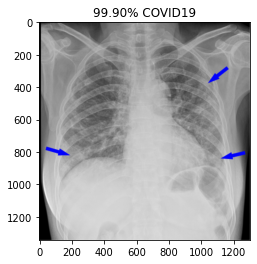

prob:[9.9984884e-01 9.7211247e-05 4.4891742e-05 9.0178983e-06]
covid/ryct.2020200028.fig1a.jpeg


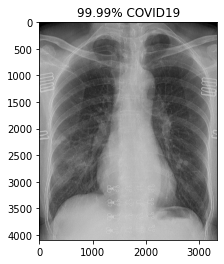

prob:[9.9942696e-01 3.9841096e-05 4.6030578e-04 7.2950308e-05]
covid/ryct.2020200034.fig2.jpeg


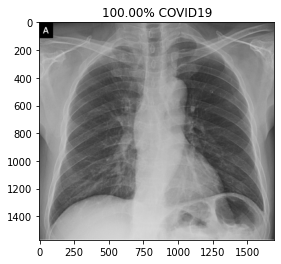

prob:[9.9992061e-01 1.6779015e-05 1.6753711e-06 6.0890085e-05]
covid/ryct.2020200034.fig5-day0.jpeg


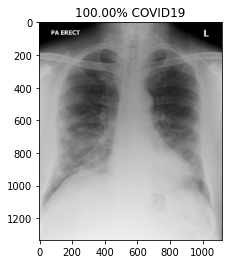

prob:[9.9978918e-01 5.7405825e-05 7.0435271e-06 1.4631424e-04]
covid/ryct.2020200034.fig5-day4.jpeg


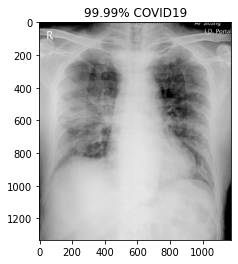

prob:[9.9928027e-01 2.0628619e-04 3.0758853e-05 4.8265219e-04]
covid/ryct.2020200034.fig5-day7.jpeg


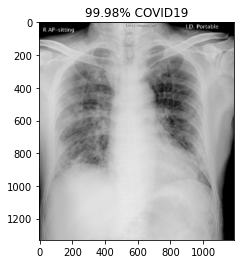

prob:[1.1229671e-02 9.7635490e-01 1.1524746e-02 8.9065463e-04]
normal/NORMAL2-IM-1385-0001.jpeg


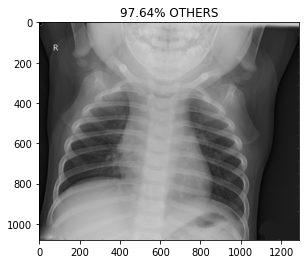

prob:[0.0078404  0.74604416 0.2453306  0.00078483]
normal/NORMAL2-IM-1396-0001.jpeg


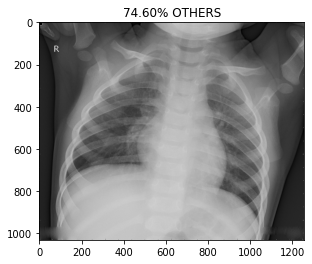

prob:[0.05865512 0.91517365 0.0206247  0.00554652]
normal/NORMAL2-IM-1400-0001.jpeg


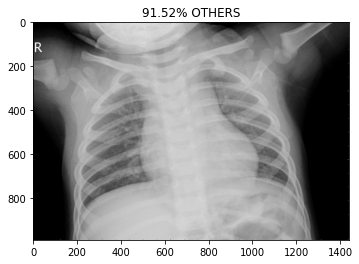

prob:[0.04555061 0.93911487 0.00457028 0.01076425]
normal/NORMAL2-IM-1401-0001.jpeg


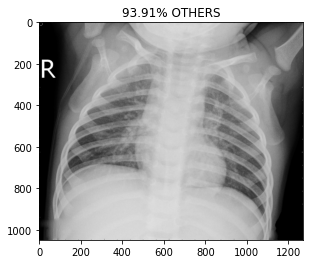

prob:[0.06964415 0.35578653 0.29080856 0.28376082]
normal/NORMAL2-IM-1406-0001.jpeg


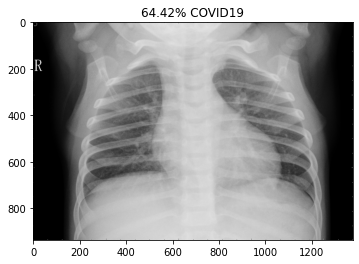

prob:[0.07695954 0.8099485  0.09881505 0.01427695]
normal/NORMAL2-IM-1412-0001.jpeg


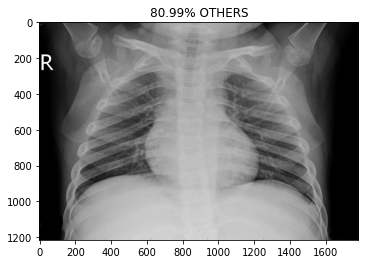

prob:[0.0068364  0.9794881  0.00993347 0.00374207]
normal/NORMAL2-IM-1419-0001.jpeg


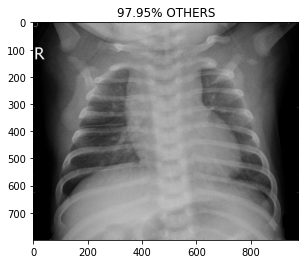

prob:[0.01742045 0.966155   0.01227276 0.0041518 ]
normal/NORMAL2-IM-1422-0001.jpeg


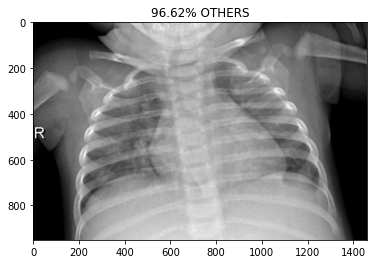

prob:[0.14505237 0.82910377 0.02060244 0.00524144]
normal/NORMAL2-IM-1423-0001.jpeg


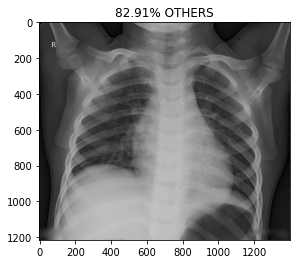

prob:[0.01471534 0.00561372 0.06077859 0.9188924 ]
pneumonia_bac/person1753_bacteria_4594.jpeg


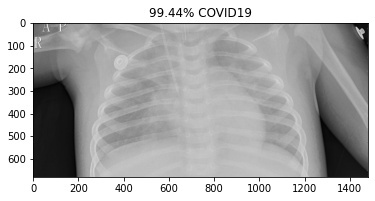

prob:[1.5788479e-04 1.7764048e-03 9.9673045e-01 1.3353329e-03]
pneumonia_bac/person1940_bacteria_4859.jpeg


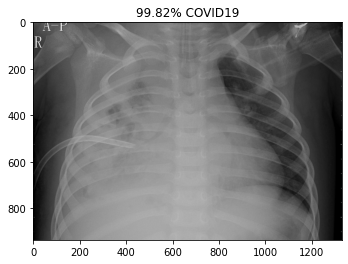

prob:[0.03071347 0.00520693 0.8439258  0.12015387]
pneumonia_bac/person1940_bacteria_4861.jpeg


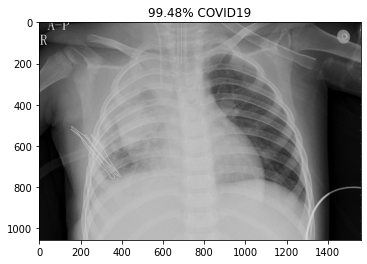

prob:[0.12690425 0.03263827 0.6472639  0.19319357]
pneumonia_bac/person1940_bacteria_4862.jpeg


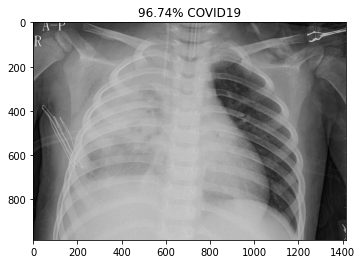

prob:[0.02855104 0.07767681 0.05815131 0.8356208 ]
pneumonia_bac/person1941_bacteria_4863.jpeg


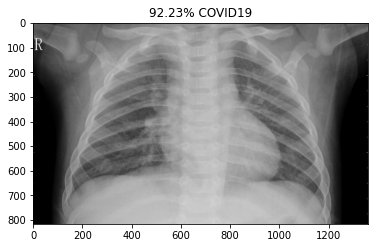

prob:[0.0235083  0.00738968 0.9650947  0.00400735]
pneumonia_bac/person1942_bacteria_4865.jpeg


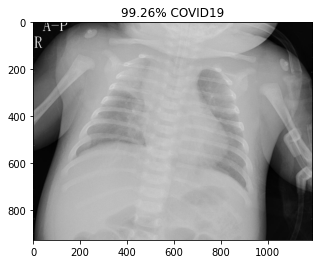

prob:[5.511562e-03 6.784485e-04 9.881216e-01 5.688302e-03]
pneumonia_bac/person1943_bacteria_4868.jpeg


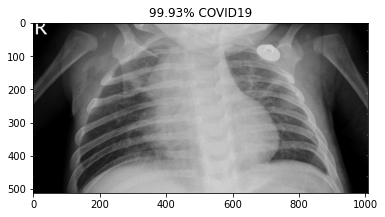

prob:[0.46568018 0.00048432 0.10513788 0.42869762]
pneumonia_bac/person1944_bacteria_4869.jpeg


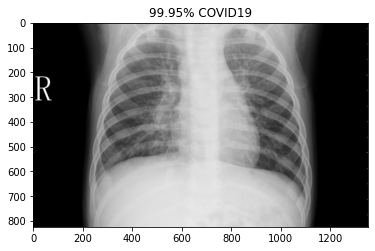

prob:[0.24012211 0.34206283 0.3782245  0.03959053]
pneumonia_bac/person1945_bacteria_4872.jpeg


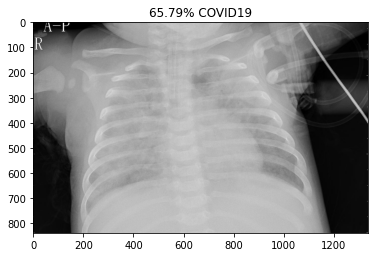

prob:[0.04409873 0.01602359 0.27154967 0.66832805]
pneumonia_vir/person957_virus_1629.jpeg


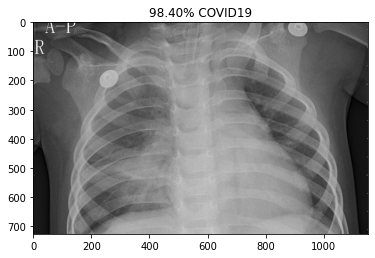

prob:[0.22311163 0.5163617  0.00590228 0.25462443]
pneumonia_vir/person958_virus_1630.jpeg


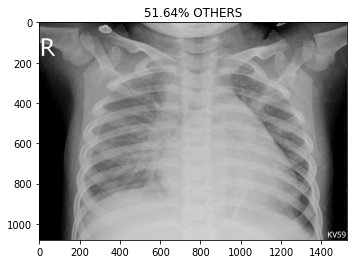

prob:[0.10023715 0.00229737 0.01254717 0.88491833]
pneumonia_vir/person960_virus_1633.jpeg


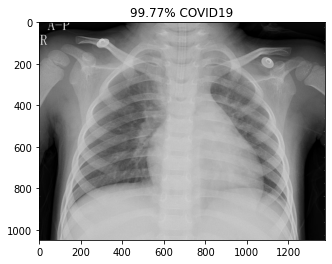

In [ ]:
import cv2
import matplotlib.image as mpimg
prediction = prediction[:30]
for index, probability in enumerate(prediction):
    image_path = test_path + "/" +test_generator.filenames[index]
    image = mpimg.imread(image_path)
     #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)
    print("prob:{}".format(probability))
    print(test_generator.filenames[index])
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% OTHERS')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID19')
    plt.show()

In [ ]:

print('Classification Report')
target_names = ['covid','normal','pneumonia_bac','pneumonia_viral']

print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Classification Report
                 precision    recall  f1-score   support

          covid       0.90      1.00      0.95         9
         normal       0.90      1.00      0.95         9
  pneumonia_bac       0.67      0.67      0.67         9
pneumonia_viral       0.71      0.56      0.63         9

       accuracy                           0.81        36
      macro avg       0.80      0.81      0.80        36
   weighted avg       0.80      0.81      0.80        36



# Test Data Prediction